# **\[GML\]** Chap7: Text Analytics and Natural Language Processing

using Graphs

신록예찬  
2023-02-10

# Text Analytics and Natural Language Processing using Graphs

In the following we will focus on analyzing textual documents and
leverage on graph analysis in order to identify insight and extract
relevant information.

In particular in the following we will show you how to:

-   Extract structured information from text by using NLP techniques and
    models
-   Build different type of graphs starting from the information
    extracted in the previous point
-   Analyze the graph

### Load Dataset

In [1]:
import nltk 

In [2]:
import numpy as np

import pandas as pd
import networkx as nx

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt

In [4]:
from nltk.corpus import reuters

In [5]:
corpus = pd.DataFrame([
    {"id": _id, "clean_text": reuters.raw(_id).replace("\n", ""), "label": reuters.categories(_id)}
    for _id in reuters.fileids()
]).set_index("id")

In [6]:
corpus.iloc[10]["clean_text"]

In [7]:
from collections import Counter
len(Counter([label for document_labels in corpus["label"] for label in document_labels]).most_common())

In [8]:
corpus.head()

### Language Detection

In [9]:
import langdetect

In [10]:
import numpy as np

def getLanguage(text: str):
    try:
        return langdetect.detect(text)
    except: 
        return np.nan

In [11]:
corpus["language"] = corpus["clean_text"].apply(getLanguage)

In [12]:
corpus["language"].value_counts().head(10)

In [13]:
corpus.head()

Using fasttext

In [14]:
!curl -w GET https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.ftz > lid.176.ftz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  916k  100  916k    0     0   547k      0  0:00:01  0:00:01 --:--:--  548k

In [15]:
import fasttext

m = fasttext.load_model("lid.176.ftz")
def getLanguage(text: str):
    return m.predict(text)[0][0].replace("__label__", "")

In [16]:
corpus["language"] = corpus["clean_text"].apply(getLanguage)

In [17]:
corpus["language"].value_counts().head(10)

In [18]:
corpus[corpus["language"]=="ja"].iloc[5]["clean_text"]

### NLP Enrichment

In [19]:
import spacy

In order to download the model from the Spacy library, please issue the
following command in a shell

In [20]:
nlp = spacy.load('en_core_web_md')

In [21]:
corpus["parsed"] = corpus["clean_text"].apply(nlp)

In [22]:
corpus.loc["test/14832"]["clean_text"]

In [23]:
from spacy import displacy

In [24]:
displacy.render(corpus.loc["test/14832"]["parsed"], style='ent', jupyter=True)

#### Export corpus Dataframe

In [162]:
corpus.head()

In [164]:
corpus[["clean_text", "label", "language", "parsed"]].to_pickle("corpus.p")

## Graph Generation

In the following, we will show you how to create two different kind of
graphs out of a corpus of documents:

-   Knowledge base graphs, where the subject-verb-object relation will
    be encoded to build a semantic graph
-   Bipartite graphs, linking documents with the entities/keywords
    appearing therein

### Knowledge base

In [25]:
from subject_object_extraction import findSVOs

In [26]:
corpus["triplets"] = corpus["parsed"].apply(lambda x: findSVOs(x, output="obj"))

In [27]:
corpus.head()

In [28]:
edge_list = [
    {"id": _id, "source": source.lemma_.lower(), "target": target.lemma_.lower(), "edge": edge.lemma_.lower()}
    for _id, triplets in corpus["triplets"].iteritems()
    for (source, (edge, neg), target) in triplets
]

In [29]:
edges = pd.DataFrame(edge_list)

In [30]:
edges["edge"].value_counts().head(10)

In [31]:
import networkx as nx

In [32]:
G=nx.from_pandas_edgelist(edges, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

In [33]:
len(G.nodes)

In [34]:
def plotDistribution(serie: pd.Series, nbins: int, minValue=None, maxValue=None):
    _minValue=int(np.floor(np.log10(minValue if minValue is not None else serie.min())))
    _maxValue=int(np.ceil(np.log10(maxValue if maxValue is not None else serie.max())))
    bins = [0] + list(np.logspace(_minValue, _maxValue, nbins)) + [np.inf]
    serie.hist(bins=bins)
    plt.xscale("log")

In [35]:
def graphSummary(graph, bins=10):
    print(nx.info(graph))
    plt.figure(figsize=(20, 8))
    plt.subplot(1,2,1)
    degrees = pd.Series({k: v for k, v in nx.degree(graph)})
    plt.yscale("log")
    plotDistribution(degrees, bins)
    try:
        plt.subplot(1,2,2)
        allEdgesWeights = pd.Series({(d[0], d[1]): d[2]["weight"] for d in graph.edges(data=True)})
        plotDistribution(allEdgesWeights, bins)
        plt.yscale("log")
    except:
        pass

In [36]:
print(nx.info(G))

Name: 
Type: MultiDiGraph
Number of nodes: 7576
Number of edges: 72263
Average in degree:   9.5384
Average out degree:   9.5384

Name: 
Type: MultiDiGraph
Number of nodes: 7576
Number of edges: 72263
Average in degree:   9.5384
Average out degree:   9.5384

/Users/deusebio/.pyenv/versions/3.7.6/envs/ml-book-7/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6694: RuntimeWarning: invalid value encountered in multiply
  boffset = -0.5 * dr * totwidth * (1 - 1 / nx)

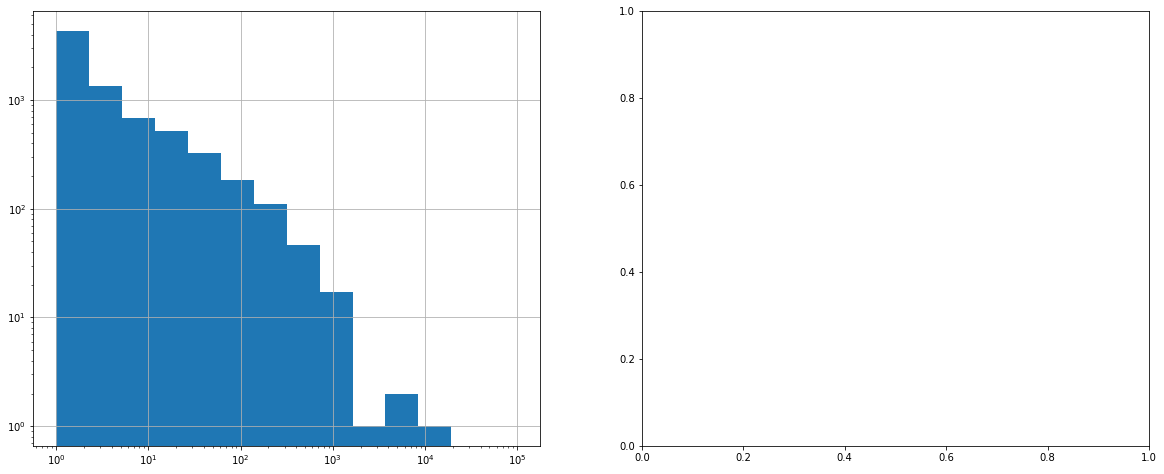

In [37]:
graphSummary(G, bins=15)

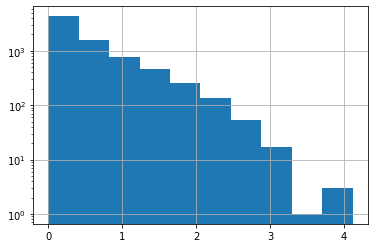

In [38]:
import numpy as np
np.log10(pd.Series({k: v for k, v in nx.degree(G)}).sort_values(ascending=False)).hist()
plt.yscale("log")

Analysis of a certain relation

In [39]:
edges.head()

In [40]:
e = edges[(edges["source"]!=" ") & (edges["target"]!=" ") & (edges["edge"]=="lend")]

In [41]:
G=nx.from_pandas_edgelist(e, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

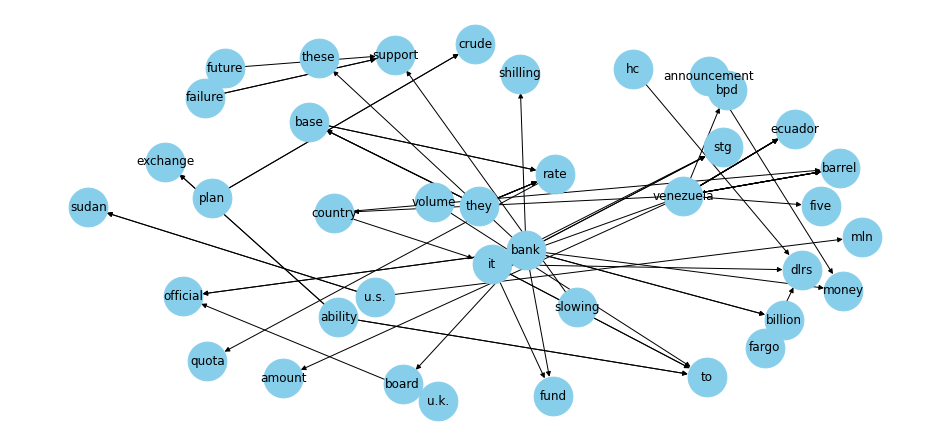

In [42]:
import os

plt.figure(figsize=(13, 6))

pos = nx.spring_layout(G, k=1.2) # k regulates the distance between nodes

nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos, font_size=12)

# plt.show()
# plt.savefig(os.path.join(".", "KnowledgeGraph.png"), dpi=300, format="png")

## Bipartite Graph

Let’s start by extracting the keywords from the documents

In [43]:
import gensim

In [44]:
from gensim.summarization import keywords 

In [45]:
text = corpus["clean_text"][0]
keywords(text, words=10, split=True, scores=True, pos_filter=('NN', 'JJ'), lemmatize=True)

In [46]:
corpus["keywords"] = corpus["clean_text"].apply(
    lambda text: keywords(text, words=10, split=True, scores=True, pos_filter=('NN', 'JJ'), lemmatize=True)
)

In [47]:
corpus.head()

In [48]:
def extractEntities(ents, minValue=1, typeFilters=["GPE", "ORG", "PERSON"]):
    entities = pd.DataFrame([
        {"lemma": e.lemma_, "lower": e.lemma_.lower(), "type": e.label_}
        for e in ents if hasattr(e, "label_")
    ])

    if len(entities)==0:
        return pd.DataFrame()
    
    g = entities.groupby(["type", "lower"])

    summary = pd.concat({
        "alias": g.apply(lambda x: x["lemma"].unique()), 
        "count": g["lower"].count()
    }, axis=1)
    
    return summary[summary["count"]>1].loc[pd.IndexSlice[typeFilters, :, :]]

def getOrEmpty(parsed, _type):
    try:
        return list(parsed.loc[_type]["count"].sort_values(ascending=False).to_dict().items())
    except:
        return []

def toField(ents):
    typeFilters=["GPE", "ORG", "PERSON"]
    parsed = extractEntities(ents, 1, typeFilters)
    return pd.Series({_type: getOrEmpty(parsed, _type) for _type in typeFilters})
    

In [49]:
entities = corpus["parsed"].apply(lambda x: toField(x.ents))

In [50]:
merged = pd.concat([corpus, entities], axis=1) 

In [51]:
merged.head()

We finally create the bipartite graph

In [52]:
edges = pd.DataFrame([
    {"source": _id, "target": keyword, "weight": score, "type": _type}
    for _id, row in merged.iterrows()
    for _type in ["keywords", "GPE", "ORG", "PERSON"] 
    for (keyword, score) in row[_type]
])

In [53]:
G = nx.Graph()
G.add_nodes_from(edges["source"].unique(), bipartite=0)
G.add_nodes_from(edges["target"].unique(), bipartite=1)
G.add_edges_from([
    (row["source"], row["target"])
    for _, row in edges.iterrows()
])

In [54]:
document_nodes = {n for n, d in G.nodes(data=True) if d["bipartite"] == 0}
entity_nodes = {n for n, d in G.nodes(data=True) if d["bipartite"] == 1}

In [55]:
nodes_with_low_degree = {n for n, d in nx.degree(G, nbunch=entity_nodes) if d<5}

In [56]:
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 25752
Number of edges: 100311
Average degree:   7.7905

In [57]:
from networkx.algorithms.bipartite.projection import overlap_weighted_projected_graph

### Entity-Entity Graph Projection

In [58]:
subGraph = G.subgraph(set(G.nodes) - nodes_with_low_degree)

In [59]:
entityGraph = overlap_weighted_projected_graph(
    subGraph, 
    {n for n, d in subGraph.nodes(data=True) if d["bipartite"] == 1}
)

In [60]:
len(entityGraph.nodes())

In [61]:
degrees = pd.Series({k: v for k, v in nx.degree(entityGraph)})

/Users/deusebio/.pyenv/versions/3.7.6/envs/ml-book-7/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6694: RuntimeWarning: invalid value encountered in multiply
  boffset = -0.5 * dr * totwidth * (1 - 1 / nx)

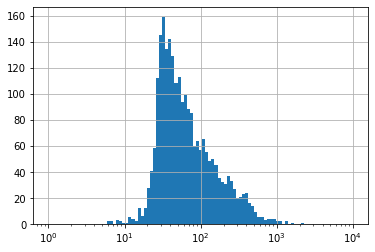

In [62]:
plotDistribution(degrees, 100)

In [63]:
print(nx.info(entityGraph))

Name: 
Type: Graph
Number of nodes: 2386
Number of edges: 120198
Average degree: 100.7527

In [64]:
allEdgesWeights = pd.Series({(d[0], d[1]): d[2]["weight"] for d in entityGraph.edges(data=True)})

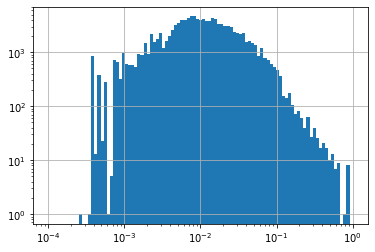

In [65]:
plotDistribution(allEdgesWeights, 100)
plt.yscale("log")

In [66]:
filteredEntityGraph = entityGraph.edge_subgraph(
    [edge for edge in entityGraph.edges if entityGraph.edges[edge]["weight"]>0.05]
)

In [67]:
print(nx.info(filteredEntityGraph))

Name: 
Type: Graph
Number of nodes: 2265
Number of edges: 8082
Average degree:   7.1364

#### Local and global properties of the graph

In [68]:
globalKpis = [{
    "shortest_path": nx.average_shortest_path_length(_graph),
    "clustering_coefficient": nx.average_clustering(_graph),
    "global_efficiency": nx.global_efficiency(_graph)
} for components in nx.connected_components(filteredEntityGraph) 
    for _graph in [nx.subgraph(filteredEntityGraph, components)]]

In [69]:
pd.concat([
    pd.DataFrame(globalKpis), 
    pd.Series([len(c) for c in nx.connected_components(filteredEntityGraph)])
], axis=1)

In [70]:
pd.Series([len(c) for c in nx.connected_components(filteredEntityGraph)]).sum()

In [71]:
globalKpis[0]

In [72]:
# nx.write_gexf(filteredEntityGraph, "filteredEntityGraph.gexf")

In [73]:
betweeness = nx.betweenness_centrality(filteredEntityGraph)

In [74]:
_betweeness = pd.Series(betweeness)

/Users/deusebio/.pyenv/versions/3.7.6/envs/ml-book-7/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6694: RuntimeWarning: invalid value encountered in multiply
  boffset = -0.5 * dr * totwidth * (1 - 1 / nx)

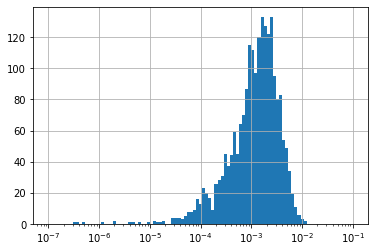

In [75]:
plotDistribution(_betweeness[_betweeness>0], 100)

In [76]:
pageRanks = pd.Series(nx.pagerank(filteredEntityGraph))

In [77]:
degrees = pd.Series({k: v for k, v in nx.degree(filteredEntityGraph)})

In [78]:
kpis = pd.concat({
    "pageRank": pageRanks, 
    "degrees": degrees, 
    "betweeness": _betweeness
}, axis=1)

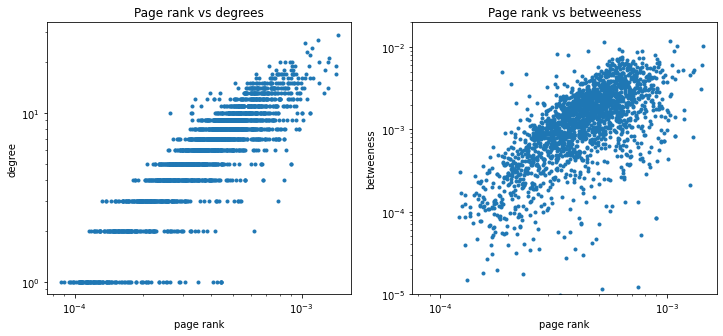

In [79]:
plt.figure(figsize=(12, 5))

plt.subplot(1,2,1)
plt.title("Page rank vs degrees")
plt.plot(kpis["pageRank"], kpis["degrees"], '.', color="tab:blue")
plt.xlabel("page rank")
plt.ylabel("degree")
plt.xscale("log")
plt.yscale("log")

plt.subplot(1,2,2)
plt.title("Page rank vs betweeness")
plt.plot(kpis["pageRank"], kpis["betweeness"], '.', color="tab:blue")
plt.xlabel("page rank")
plt.ylabel("betweeness")
plt.xscale("log")
plt.yscale("log")
plt.ylim([1E-5, 2E-2])

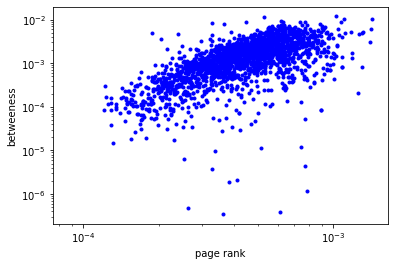

In [80]:
plt.figure(figsize=(6,4))
plt.plot(kpis["pageRank"], kpis["betweeness"], 'b.')
plt.xlabel("page rank")
plt.ylabel("betweeness")
plt.xscale("log")
plt.yscale("log")

/Users/deusebio/.pyenv/versions/3.7.6/envs/ml-book-7/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6694: RuntimeWarning: invalid value encountered in multiply
  boffset = -0.5 * dr * totwidth * (1 - 1 / nx)

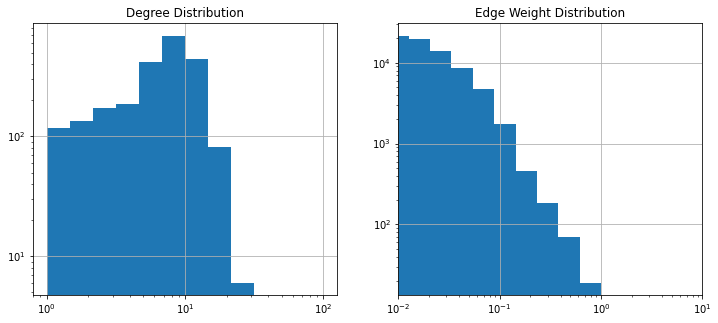

In [81]:
plt.figure(figsize=(12, 5))

plt.subplot(1,2,1)
plotDistribution(degrees, 13)
plt.yscale("log")
plt.title("Degree Distribution")

plt.subplot(1,2,2)
plotDistribution(allEdgesWeights, 20)
plt.xlim([1E-2, 10])
plt.yscale("log")
plt.title("Edge Weight Distribution")


In [82]:
allEdgesWeights = pd.Series({(d[0], d[1]): d[2]["weight"] for d in filteredEntityGraph.edges(data=True)})

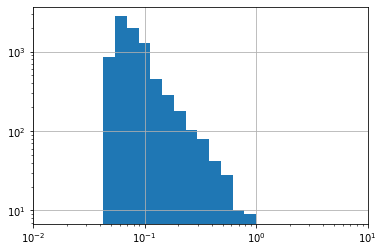

In [83]:
plotDistribution(allEdgesWeights, 20)
plt.xlim([1E-2, 10])
plt.yscale("log")

#### Visualization of the Network

In [84]:
#Create network layout for visualizations
spring_pos = nx.spring_layout(filteredEntityGraph)

In [85]:
default_edge_color = 'gray'
default_node_color = '#407cc9'
enhanced_node_color = '#f5b042'
enhanced_edge_color = '#cc2f04'

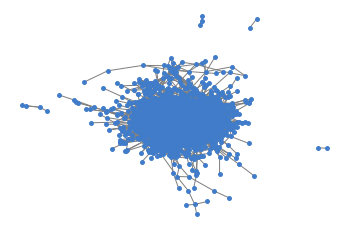

In [86]:
plt.axis("off")
nx.draw_networkx(filteredEntityGraph, pos=spring_pos, node_color=default_node_color, 
                 edge_color=default_edge_color, with_labels=False, node_size=15)

#### Community detection

In [89]:
import community

In [90]:
communities = pd.Series(community.best_partition(filteredEntityGraph))

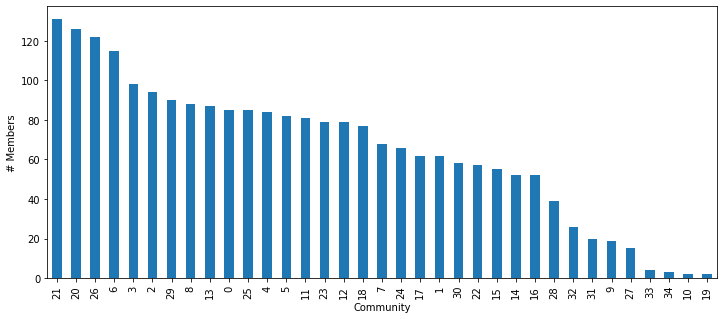

In [91]:
communities.value_counts().sort_values(ascending=False).plot(kind="bar", figsize=(12, 5))
plt.xlabel("Community")
plt.ylabel("# Members")

In [92]:
communities.loc["turkish"]

In [93]:
nodes = communities[communities==17].index

In [94]:
nodes

In [95]:
smallGrap = nx.subgraph(filteredEntityGraph, nbunch=nodes)

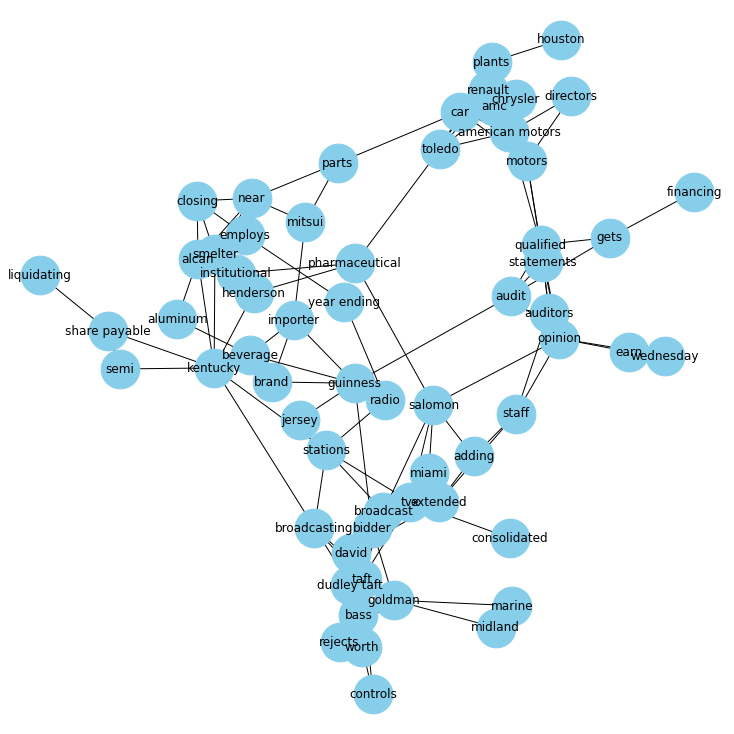

In [96]:
plt.figure(figsize=(10,10))

pos = nx.spring_layout(smallGrap) # k regulates the distance between nodes

nx.draw(smallGrap, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)

# plt.show()
# plt.savefig(os.path.join(".", "CloseUp.png"), dpi=300, format="png")

Here we show a Bipartite Closeup of the cluster

In [97]:
bipartiteCloseup = subGraph.edge_subgraph(
    {e for e in subGraph.edges() if len(set(e).intersection(nodes))>0}
)

deg = nx.degree(bipartiteCloseup)

smallGrap = nx.subgraph(bipartiteCloseup, {n for n, d in bipartiteCloseup.nodes(data=True) if d["bipartite"]==1 or deg[n]>1})

In [98]:
len([n for n, d in bipartiteCloseup.nodes(data=True) if d["bipartite"]==0])

In [99]:
len(nodes)

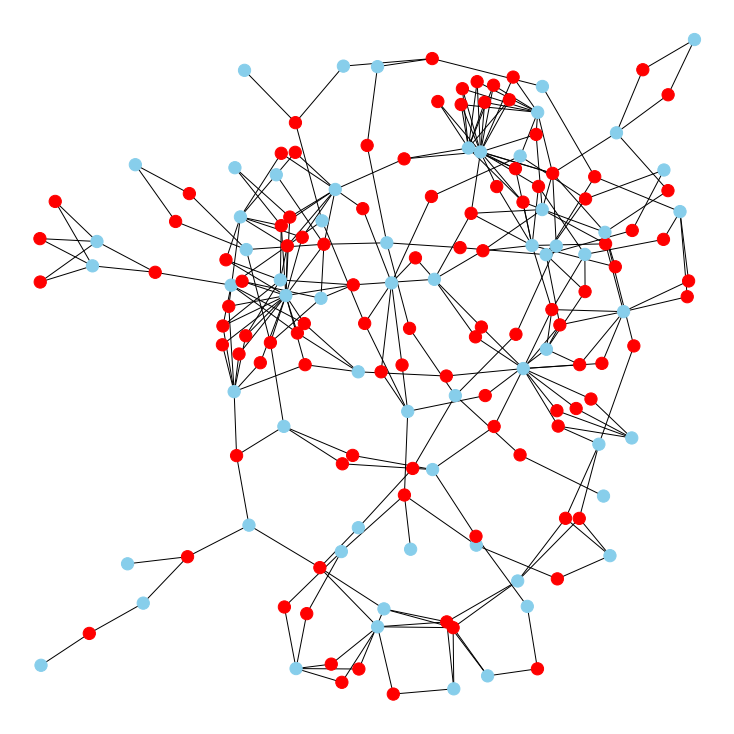

In [100]:
plt.figure(figsize=(10,10))

pos = nx.kamada_kawai_layout(smallGrap) # k regulates the distance between nodes

node_color = ["skyblue" if d["bipartite"]==1 else "red" for n, d in smallGrap.nodes(data=True)]

nx.draw(smallGrap, with_labels=False, node_color=node_color, #'skyblue', 
        node_size=150, edge_cmap=plt.cm.Blues, pos = pos)


# plt.show()
# plt.savefig(os.path.join(".", "BipartiteCloseUp.png"), dpi=300, format="png")

#### Embeddings

Using TSNE

In [101]:
from node2vec import Node2Vec

node2vec = Node2Vec(filteredEntityGraph, dimensions=5) 
model = node2vec.fit(window=10) 
embeddings = model.wv 

Generating walks (CPU: 1): 100%|██████████| 10/10 [01:45<00:00, 10.55s/it]

In [102]:
from sklearn.manifold import TSNE
tsne=TSNE(n_components=2)
embedding2d=tsne.fit_transform(embeddings.vectors)

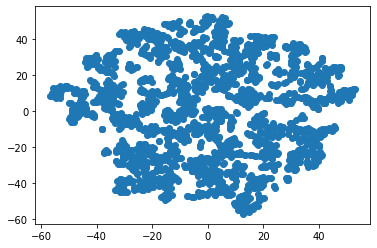

In [103]:
plt.plot(embedding2d[:, 0], embedding2d[:, 1], 'o')

Using Node2Vec

Node2Vec allows also to compute a similarity between entities

In [104]:
embeddings.most_similar(positive=["turkey"])

### Document-Document Graph Projection

In [105]:
from networkx.algorithms.bipartite.projection import overlap_weighted_projected_graph

In [106]:
documentGraph = overlap_weighted_projected_graph(
    G, 
    {n for n, d in G.nodes(data=True) if d["bipartite"] == 0}
)

In [107]:
from matplotlib import pyplot as plt

In [108]:
print(nx.info(documentGraph))

Name: 
Type: Graph
Number of nodes: 10788
Number of edges: 12994465
Average degree: 2409.0591

In [109]:
degrees = pd.Series({k: v for k, v in nx.degree(documentGraph)})

/Users/deusebio/.pyenv/versions/3.7.6/envs/ml-book-7/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6694: RuntimeWarning: invalid value encountered in multiply
  boffset = -0.5 * dr * totwidth * (1 - 1 / nx)

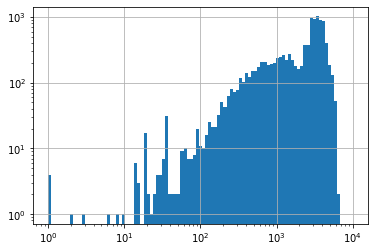

In [110]:
plotDistribution(degrees, 100)
plt.yscale("log")

In [111]:
allEdgesWeights = pd.Series({(d[0], d[1]): d[2]["weight"] for d in documentGraph.edges(data=True)})

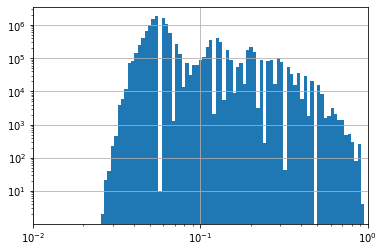

In [112]:
plotDistribution(allEdgesWeights, 100)
plt.yscale("log")
plt.xlim([1E-2, 1])

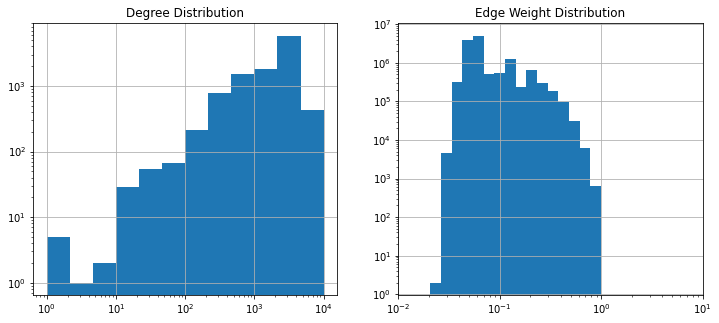

In [113]:
plt.figure(figsize=(12, 5))

plt.subplot(1,2,1)
plotDistribution(degrees, 13)
plt.yscale("log")
plt.title("Degree Distribution")

plt.subplot(1,2,2)
plotDistribution(allEdgesWeights, 20)
plt.xlim([1E-2, 10])
plt.yscale("log")
plt.title("Edge Weight Distribution")

In [114]:
filteredDocumentGraph = documentGraph.edge_subgraph(
    allEdgesWeights[(allEdgesWeights>0.6)].index.tolist()
)

In [115]:
print(nx.info(filteredDocumentGraph))

Name: 
Type: Graph
Number of nodes: 1958
Number of edges: 7884
Average degree:   8.0531

#### Global and Local Properties

In [116]:
degrees = pd.Series({k: v for k, v in nx.degree(filteredDocumentGraph)})

/Users/deusebio/.pyenv/versions/3.7.6/envs/ml-book-7/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6694: RuntimeWarning: invalid value encountered in multiply
  boffset = -0.5 * dr * totwidth * (1 - 1 / nx)

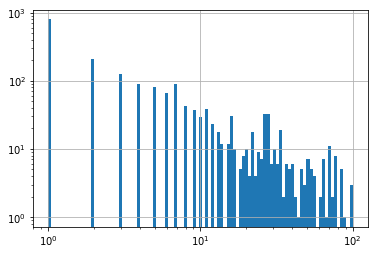

In [117]:
plotDistribution(degrees, 100)
plt.yscale("log")

In [118]:
allEdgesWeights = pd.Series({(d[0], d[1]): d[2]["weight"] for d in filteredDocumentGraph.edges(data=True)})

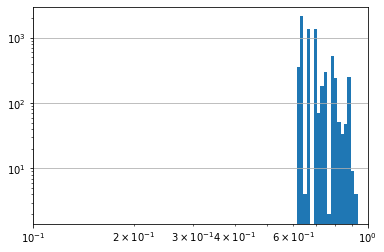

In [119]:
plotDistribution(allEdgesWeights, 100)
plt.yscale("log")
plt.xlim([1E-1, 1])

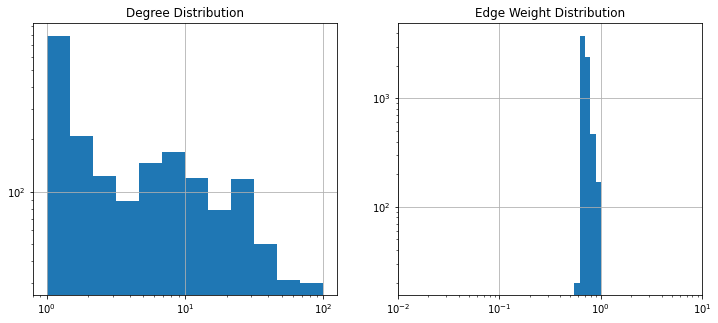

In [120]:
plt.figure(figsize=(12, 5))

plt.subplot(1,2,1)
plotDistribution(degrees, 13)
plt.yscale("log")
plt.title("Degree Distribution")

plt.subplot(1,2,2)
plotDistribution(allEdgesWeights, 20)
plt.xlim([1E-2, 10])
plt.yscale("log")
plt.title("Edge Weight Distribution")

#### Core - Periphery Description and Analysis

In [121]:
#Create network layout for visualizations
spring_pos = nx.spring_layout(filteredDocumentGraph)

In [122]:
default_edge_color = 'gray'
default_node_color = '#407cc9'
enhanced_node_color = '#f5b042'
enhanced_edge_color = '#cc2f04'

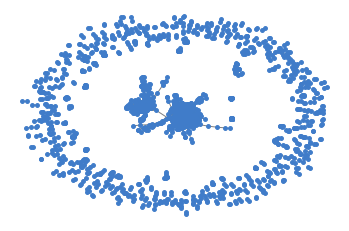

In [123]:
plt.axis("off")
nx.draw_networkx(filteredDocumentGraph, pos=spring_pos, node_color=default_node_color, 
                 edge_color=default_edge_color, with_labels=False, node_size=15)

In [124]:
components = pd.Series({ith: component 
              for ith, component in enumerate(nx.connected_components(filteredDocumentGraph))})

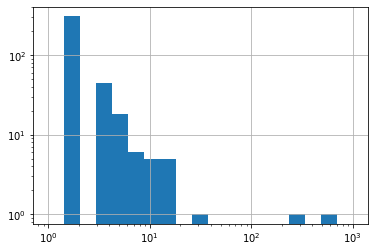

In [125]:
plotDistribution(components.apply(len), nbins=20)
plt.yscale("log")

In [126]:
coreDocumentGraph = nx.subgraph(
    filteredDocumentGraph,
    [node for nodes in components[components.apply(len)>8].values for node in nodes]
)

# To be visualized in Gephi

nx.write_gexf(coreDocumentGraph,“coreGraph.gexf”)

In [127]:
print(nx.info(coreDocumentGraph))

Name: 
Type: Graph
Number of nodes: 1050
Number of edges: 7112
Average degree:  13.5467

In [128]:
degrees = pd.Series({k: v for k, v in nx.degree(coreDocumentGraph)})

/Users/deusebio/.pyenv/versions/3.7.6/envs/ml-book-7/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6694: RuntimeWarning: invalid value encountered in multiply
  boffset = -0.5 * dr * totwidth * (1 - 1 / nx)

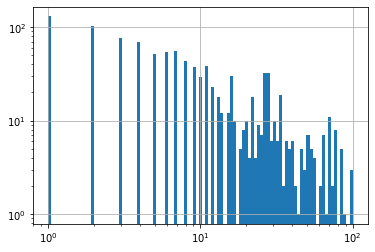

In [129]:
plotDistribution(degrees, 100)
plt.yscale("log")

In [130]:
allEdgesWeights = pd.Series({(d[0], d[1]): d[2]["weight"] for d in coreDocumentGraph.edges(data=True)})

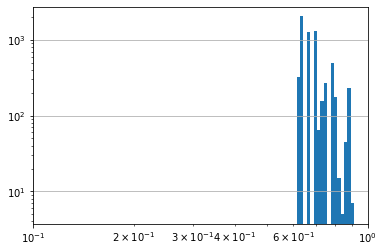

In [131]:
plotDistribution(allEdgesWeights, 100)
plt.yscale("log")
plt.xlim([1E-1, 1])

In [132]:
#Create network layout for visualizations
spring_pos = nx.spring_layout(coreDocumentGraph)

In [133]:
default_edge_color = 'gray'
default_node_color = '#407cc9'
enhanced_node_color = '#f5b042'
enhanced_edge_color = '#cc2f04'

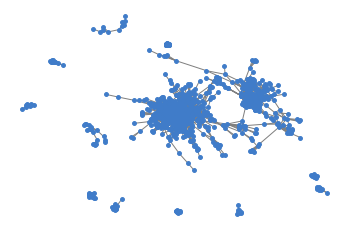

In [134]:
plt.axis("off")
nx.draw_networkx(coreDocumentGraph, pos=spring_pos, node_color=default_node_color, 
                 edge_color=default_edge_color, with_labels=False, node_size=15)

#### Community Detection and Topics Clustering

In [135]:
import community

In [136]:
communities = pd.Series(community.best_partition(coreDocumentGraph))

In [137]:
communities = pd.Series(community.best_partition(filteredDocumentGraph))

In [138]:
from collections import Counter

def getTopicRatio(df):
    return Counter([label for labels in df["label"] for label in labels])

In [139]:
communityTopics = pd.DataFrame.from_dict({
    cid: getTopicRatio(corpus.loc[comm.index])
    for cid, comm in communities.groupby(communities)
}, orient="index")

In [140]:
normalizedCommunityTopics = (communityTopics.T / communityTopics.sum(axis=1)).T

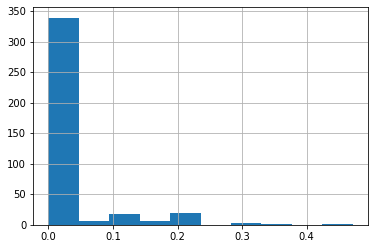

In [141]:
normalizedCommunityTopics.std(axis=1).fillna(0).hist()

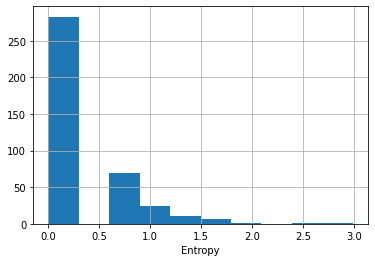

In [142]:
normalizedCommunityTopics.apply(lambda x: np.mean(-np.log(x)), axis=1).hist()
plt.xlabel("Entropy")

In [143]:
topicsCorrelation = normalizedCommunityTopics.corr().fillna(0)
topicsCorrelation[topicsCorrelation<0.8]=0


In [144]:
topicsGraph = nx.from_pandas_adjacency(topicsCorrelation)

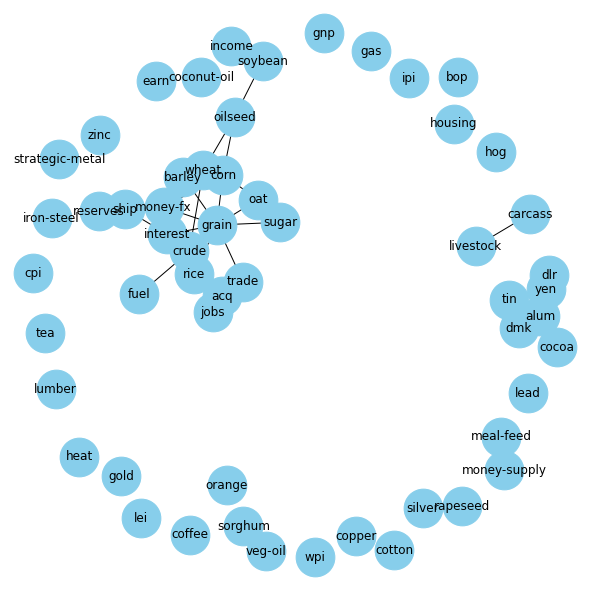

In [145]:
plt.figure(figsize=(8,8))

pos = nx.spring_layout(topicsGraph, k=0.35) # k regulates the distance between nodes

nx.draw(topicsGraph, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)

# plt.show()
# plt.savefig(os.path.join(".", "TopicsAll.png"), dpi=300, format="png")

In [146]:
filteredTopicsGraph = nx.subgraph(
    topicsGraph,
    [node for component in nx.connected_components(topicsGraph) if len(component)>3 for node in component]
)

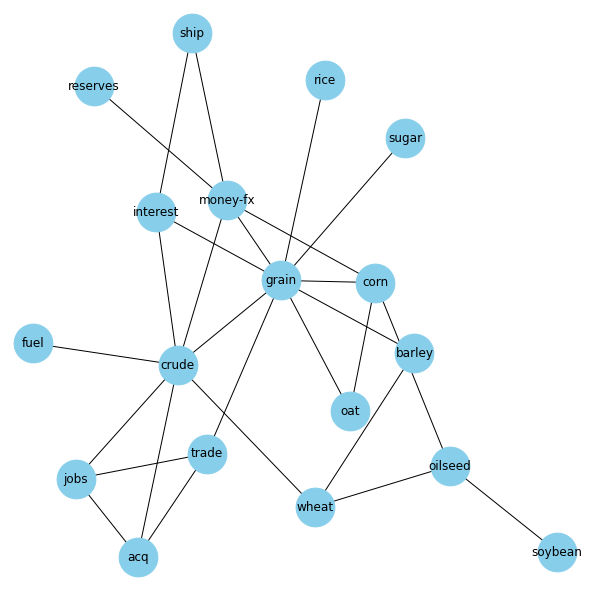

In [147]:
plt.figure(figsize=(8,8))

pos = nx.kamada_kawai_layout(filteredTopicsGraph) # k regulates the distance between nodes

nx.draw(filteredTopicsGraph, with_labels=True, node_color='skyblue', node_size=1500, 
        edge_cmap=plt.cm.Blues, pos = pos)

# plt.show()
# plt.savefig(os.path.join(".", "TopicsCore.png"), dpi=300, format="png")

# To be visualized in Gephi

nx.write_gexf(coreDocumentGraph, “coreDocumentGraph”)

#### Embeddings for the Document-Document Graph

In [148]:
from node2vec import Node2Vec

node2vec = Node2Vec(coreDocumentGraph, dimensions=20) 
model = node2vec.fit(window=10) 
embeddings = model.wv 

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:47<00:00,  4.70s/it]

In [149]:
from sklearn.manifold import TSNE

tsne=TSNE(n_components=2)

In [150]:
embedding2d=tsne.fit_transform(embeddings.vectors)

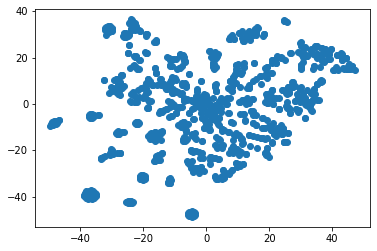

In [151]:
plt.plot(embedding2d[:, 0], embedding2d[:, 1], 'o')

In [152]:
pd.DataFrame(embeddings.vectors)

In [153]:
pd.DataFrame(embeddings.vectors, index=embeddings.index2word)

In [154]:
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 25752
Number of edges: 100311
Average degree:   7.7905

Extracting the embeddings to be used in shallow-learning models. Please
do vary the *dimensions* and the *window* parameters to generate
multiple combination to be cross-validated

In [159]:
from pathlib import Path
Path("./embeddings").mkdir(parents=True, exist_ok=True)

In [155]:
from node2vec import Node2Vec

dimensions = 10
window = 20

node2vec = Node2Vec(G, dimensions=dimensions) 
model = node2vec.fit(window=window) 
embeddings = model.wv 

pd.DataFrame(embeddings.vectors, index=embeddings.index2word)\
    .to_pickle(f"./embeddings/bipartiteGraphEmbeddings_{dimensions}_{window}.p")

Generating walks (CPU: 1): 100%|██████████| 10/10 [34:19<00:00, 205.97s/it]